<a href="https://colab.research.google.com/github/shivanggarg1998/Suggestion-Mining/blob/master/CNNFastTextAttentionSMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

# FOR PLOTTING GRAPHS
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',300)

# FOR CNN MODEL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding;
from tensorflow.keras.layers import concatenate, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout

# FOR ATTENTION LAYER
from tensorflow.keras.layers import Attention, Flatten,Activation,Permute,RepeatVector,Lambda,Multiply
from tensorflow.keras.backend import sum as Ksum

# FOR EVALUATION METRICS OF THE PREDICTIONS
from sklearn.metrics import accuracy_score,f1_score,classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Suggestion-Mining2/master')

In [271]:
# IMPORITING THE PARAMENTERS AND SEQUENCES 
import pickle

variables = pickle.load(open('./Data/variablesFastTextSMOTE','rb'))

test_sequence  = variables['test_sequence']
valid_sequence  = variables['valid_sequence']
train_sequence  = variables['train_sequence']

y_train  = variables['y_train']
y_test  = variables['y_test']
y_valid  = variables['y_valid']

MXSEQLEN  = variables['MXSEQLEN']
EMBEDDING_DIM  = variables['EMBEDDING_DIM']
train_embedding_weights  = variables['train_embedding_weights']
train_word_index  = variables['train_word_index']
train_sequence

array([[   0,    0,    0, ...,  839,   34,  330],
       [   0,    0,    0, ...,  630,    2, 1735],
       [   0,    0,    0, ...,   80,  806,   87],
       ...,
       [   0,    0,    0, ...,   35,  139,   85],
       [   0,    0,    0, ...,   65, 1355, 1261],
       [   0,    0,    0, ...,  280,  866,  188]], dtype=int32)

In [0]:
def CNN(embedding_weights,num_words):

    embedding_layer = Embedding(
        num_words,                  # VOCABULARY SIZE
        EMBEDDING_DIM,              # ONE HOT ENCODING VECTOR SIZE
        weights=[embedding_weights],# EMBEGGING WEIGHTS FROM THE GOOGLE NEW WORD VECTOR
        input_length=MXSEQLEN,      # MAX LENGTH OF A SEQUENCE
        trainable=False             # PARAMETERS WILL NOT BE TRAINED
    )

    sequence_input      =   Input(shape=(MXSEQLEN,), dtype='int32')
    embedded_sequences  =   embedding_layer(sequence_input)

    # CONVOLUTIONAL LAYER 1
    conv_layer1 = Conv1D(256, 2, activation='relu')(embedded_sequences)        
    conv_layer1 = GlobalMaxPooling1D()(conv_layer1)

    # CONVOLUTIONAL LAYER 2
    conv_layer2 = Conv1D(256, 3, activation='relu')(embedded_sequences)        
    conv_layer2 = GlobalMaxPooling1D()(conv_layer2)

    # CONVOLUTIONAL LAYER 3
    conv_layer3 = Conv1D(256, 4, activation='relu')(embedded_sequences)        
    conv_layer3 = GlobalMaxPooling1D()(conv_layer3)

    # CONCATENATION CONV LAYERS
    next_layer = concatenate([conv_layer1,conv_layer2,conv_layer3])

    # ADDING ATTENTION
    units = 256
    next_layer = Dense(256, activation='sigmoid')(next_layer)  
    attention = Dense(1, activation='tanh')(next_layer)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(units)(attention)
    attention = Permute([2, 1])(attention)

    sent_representation = Multiply()([next_layer, attention])
    sent_representation = Lambda(lambda xin: Ksum(xin, axis=-2), output_shape=(units,))(sent_representation)

    next_layer = Dropout(0.6)(next_layer)                         
    next_layer = Dense(128, activation='sigmoid')(next_layer)  

    preds = Dense(1, activation='sigmoid')(next_layer)  

    model = Model(sequence_input, preds)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['acc']
    )
    
    model.summary()
    return model

In [273]:
# len= train_word_index +1 FOR 0 THAT WILL BE PADDED FOR COMPLETING THE SEQUENCE LENGTH
cnn_model = CNN(train_embedding_weights, len(train_word_index)+1)  

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 126)]        0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 126, 300)     1171500     input_32[0][0]                   
__________________________________________________________________________________________________
conv1d_93 (Conv1D)              (None, 125, 256)     153856      embedding_31[0][0]               
__________________________________________________________________________________________________
conv1d_94 (Conv1D)              (None, 124, 256)     230656      embedding_31[0][0]               
___________________________________________________________________________________________

In [274]:
# CONFIGURING AND TRAINING THE MODEL
EPOCHS = 5
BATCH_SIZE = 50

history = cnn_model.fit(
    train_sequence,       # THE INPUT SEQUENCES TO THE MODEL
    y_train,              # TARGET OUTPUT
    epochs=EPOCHS,    
    validation_data=(valid_sequence, y_valid), 
    shuffle=True, 
    batch_size=BATCH_SIZE
)

Epoch 1/5
193/193 [==============================] - 2s 9ms/step - loss: 0.4989 - acc: 0.7560 - val_loss: 0.2721 - val_acc: 0.8908
Epoch 2/5
193/193 [==============================] - 2s 8ms/step - loss: 0.3406 - acc: 0.8555 - val_loss: 0.3078 - val_acc: 0.8619
Epoch 3/5
193/193 [==============================] - 2s 8ms/step - loss: 0.2328 - acc: 0.9060 - val_loss: 0.2465 - val_acc: 0.9004
Epoch 4/5
193/193 [==============================] - 2s 8ms/step - loss: 0.1354 - acc: 0.9544 - val_loss: 0.3623 - val_acc: 0.8643
Epoch 5/5
193/193 [==============================] - 2s 8ms/step - loss: 0.0870 - acc: 0.9745 - val_loss: 0.4004 - val_acc: 0.8583


In [0]:
#####################################################################################
########################## ANALYZING AND TWEAKING THE MODEL##########################
#####################################################################################

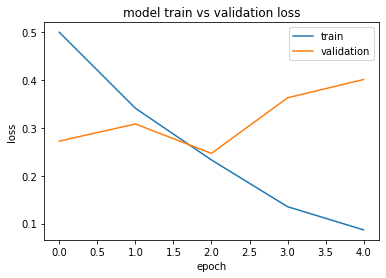

In [276]:
# TRAINING VS VALIDATION LOSS GRAPH
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
predict=cnn_model.predict(test_sequence)
predict=[int(x+0.5) for x in predict]

In [278]:
# EVLUATING THE ACCURACY
accuracy = accuracy_score(y_test, predict)
f1=f1_score(y_test,predict)
print("F1 Score: %.2f%%" % (f1* 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test,predict))

F1 Score: 77.42%
Accuracy: 77.53%
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       296
           1       0.78      0.77      0.77       296

    accuracy                           0.78       592
   macro avg       0.78      0.78      0.78       592
weighted avg       0.78      0.78      0.78       592

